MLP implementation of ngram language model of context 3.

In [1]:
import torch
import torch.nn.functional as F
#plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../names.txt','r').read().splitlines()

In [3]:
chars = ['.']+[chr(ch) for ch in range(ord('a'),ord('z')+1)]
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [178]:
def build_datasets(words):
    X,Y=[],[]
    context_len = 3

    for word in words: #exp
        context = [0]*context_len
        for w  in list(word)+['.']:
            X.append(context)
            Y.append(stoi[w])
            context= context[1:]+[stoi[w]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(407)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr,Ytr = build_datasets(words[:n1])
Xdev,Ydev = build_datasets(words[n1:n2])
Xte,Yte = build_datasets(words[n2:])


In [179]:
print(f' Training set: {Xtr.shape,Ytr.shape}')
print(f' Dev set: {Xdev.shape,Ydev.shape}')
print(f' Test set: {Xte.shape,Yte.shape}')

 Training set: (torch.Size([182502, 3]), torch.Size([182502]))
 Dev set: (torch.Size([22854, 3]), torch.Size([22854]))
 Test set: (torch.Size([22790, 3]), torch.Size([22790]))


Parameters

In [11]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,W2,b1,b2]

In [12]:
for p in parameters:
    p.requires_grad=True

Training

In [46]:
#track sets
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [174]:
step_size = 10**(-1.8)
batch_size = (32,)
track_loss = []
lri = []
for i in range(1):
    #mini batch construct
    ix = torch.randint(0,Xtr.shape[0],batch_size)

    #forward
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6)@W1+b1) #(32,100)
    logits = h@W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Ytr[ix])

    #backward
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    # step_size = lrs[i]
    for p in parameters:
        p.data+= -p.grad*step_size
    
    #track sets
    # track_loss.append(loss.item())
    # lri.append(lre[i])
print(loss.item())

2.0755157470703125


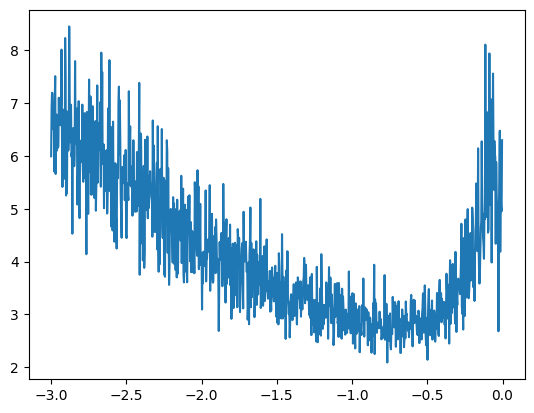

In [53]:
plt.plot(lri[:len(lri)-1],track_loss[1:])

Conclusion: learning rate of 10**-0.8 appears to be giving a slow increment of loss.

Evaluation using the dev set.

In [181]:
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,6)@W1+b1) #(32,100)
logits = h@W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ydev) 
loss

tensor(2.3806, grad_fn=<NllLossBackward0>)

Saving the model parameters

In [61]:
# torch.save(parameters,'../Model_backup/mlp_parameters.pth') #Storing the data in Model_backup folder

Loading the parameters

In [180]:
# parameters = torch.load('../Model_backup/mlp_parameters.pth')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6736\2163206376.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load('../Model_backup/mlp_parameters.pth'